# Lesson 0026 - APPLE Time Series Prediction Recurrent Neural Network
In the previous lessons, we worked on image classification using convolutional neural networks.<br>
Now we turn to sequential data.<br>
In this lesson, we build a simple model to predict the stock price of APPLE.<br>
For this, we will first get the stock prices of APPLE, then we learn about the idea behind [Recurrent Neural Networks](https://en.wikipedia.org/wiki/Recurrent_neural_network), and finally, we code a predictor.<br>
We start by stealing code from [lesson 0025](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0025_mnist_classification_convolutional_neural_network_transfer_learning.ipynb):

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [3]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


Now, we use [yfinance](https://pypi.org/project/fix-yahoo-finance/) to get the stock prices.

In [4]:
import yfinance as yf 

print( yf.__version__ )

0.1.43


We need the [Datetime package](https://docs.python.org/3/library/datetime.html) for setting the time stamps for the import of the time series data.

In [5]:
import datetime as dt

Now we can actually set the time stamps and import the data. For this experiment, we will use a $5$ year span.<br>
This is due to the fact, that we can only pull $5$ years of data from [Yahoo Finance](https://de.finance.yahoo.com/).<br>
For the computation of the current date, we employ the function [now](https://docs.python.org/3/library/datetime.html#datetime.datetime.now) and [strftime](https://docs.python.org/2/library/time.html#time.strftime). 

In [6]:
end = dt.datetime.now().strftime('%Y-%m-%d')

start = dt.datetime.now().strftime('%Y-%m-%d')




start_year = start[ 0 : 4 ]

start_year = int( start_year )

start_year = start_year - 5

start_year = str( start_year )

start = start_year + start[ 4 : len( start ) ] 



data = yf.download( 'AAPL', start, end )

[*********************100%***********************]  1 of 1 downloaded


Let's have a look a the data:

In [7]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-06-23,91.32,91.62,90.60,90.83,83.25,43694000
2014-06-24,90.75,91.74,90.19,90.28,82.74,39036000
2014-06-25,90.21,90.70,89.65,90.36,82.82,36869000
2014-06-26,90.37,91.05,89.80,90.90,83.31,32629000
2014-06-27,90.82,92.00,90.77,91.98,84.30,64029000
2014-06-30,92.10,93.73,92.09,92.93,85.17,49482300
2014-07-01,93.52,94.07,93.13,93.52,85.71,38223000
2014-07-02,93.87,94.06,93.09,93.48,85.68,28465000
2014-07-03,93.67,94.10,93.20,94.03,86.18,22891800


Now we plot the closing prices, since we will build a model for these:

C:\Users\rhopi\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Price ($)')

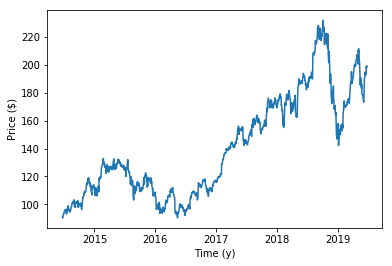

In [8]:
plt.plot( data.Close )

plt.xlabel( 'Time (y)' )

plt.ylabel( 'Price ($)' )

We see, that the stock price of APPLE is not a [stationary process](https://en.wikipedia.org/wiki/Stationary_process).<br>
This means, that the stock price changes its mean over the considered time period as well as the standard deviation.<br>
Next, we split the data set into a __training set__ of $1000$ data points, and a __test set__:

In [9]:
prices = data.Close.values

train = prices[ 0 : 1000 ]

test = prices[ 1000 : len( prices ) ]

Next, we standardize the data:

In [10]:
mu = np.mean( train )

sigma = np.std( train )


train = ( train - mu ) / sigma

test = ( test - mu ) / sigma

Now that we have prepared the data, let's find out out, what recurrent neural networks actually are: the basic assumption is, that there exists a signal $x_{ t }$ and a hidden state $h_{ t }$. In a recurrent neural network, the signal $x_{ t }$ and the hidden state from the previous point in time $h_{ t - 1 }$ are used to compute the current hidden state $h_{ t }$, and this current state is used to compute the current value $y_{ t }$. Therefore <br>
$\left( \begin{array}{c} h_{ t }\\ y_{ t }\end{array}\right) = \left( \begin{array}{c} \sigma_{ h } \left( W_{ h } h_{ t - 1 } + W_{ x } x_{ t } + b_{ h } \right) \\ \sigma_{ y } \left( W_{ y } h_{ t } + b_{ y }\right) \end{array}\right)$<br>
Here, $\sigma_{ h }$ and $\sigma_{ y }$ are activation functions, $W_{ h }, W_{ x }$ and $W_{ y }$ are weight matrices and $b_{ h }$ and $b_{ y }$ are bias vectors.<br>
The problem with this model is, that the gradients that are used to update the weights tend to explode. This is due to the fact, that each state depends on its predecessor, and therefore the last state depends on the first state.<br>
One approach to circumvene this problem is to introduce a "forget gate" which renders the past before a certain time step irrevelant for the current state. This is expressed in the so called __long short term memory (LSTM)__ [model](https://en.wikipedia.org/wiki/Long_short-term_memory).<br>
We will build a network of $32$ LSTM cells. We will use the past $32$ closing prices to predict the current closing price. For this, we employ [LSTMCell](https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell/LSTMCell) for the LSTM cell. To compute the output of a LSTM cell, we employ [dynamic_rnn](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn).

In [11]:
x_tf = tf.placeholder( tf.float32, shape = [ None, 32, 1 ] )

y_tf = tf.placeholder( tf.float32, shape = [ None, 1 ] )



lstm1 = tf.nn.rnn_cell.LSTMCell( 32, state_is_tuple = True )

lstm1_out, _ = tf.nn.dynamic_rnn( lstm1, x_tf, dtype = tf.float32 )

lstm1_out2 = lstm1_out[ :, -1, : ]



W_tf = tf.Variable( tf.truncated_normal( [ 32, 1 ] ) )

b_tf = tf.Variable( tf.truncated_normal( [ 1 ] ) )

output = tf.matmul( lstm1_out2, W_tf ) + b_tf 

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In order to perform the training, we use gradient descent. Our loss function will be [R squared](https://en.wikipedia.org/wiki/Coefficient_of_determination). R squared relates the variance between the predicted values and the true values:<br>
$R^{ 2 } = 1 - \frac{ \sum \left( y - p \right)^{ 2 } }{ \sum \left( y - \mu \right)^{ 2 } }$<br>
where $y$ is the true data, $p$ is the predicted data and $\mu$ is the mean of the measured data.<br>
If the predicted data approximate the measured data perfectly, then $R^{ 2 }$ will be $1$. If the predicted data vary around the measured data to the same degree as the measured data vary around their mean, then $R^{ 2 }$ will be $0$. A model is decent if $R^{ 2 }$ is greater than $0.7$.<br>
We employ [reduce_sum](https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum) to make the sums.<br>
Since we use gradient descent to minimize the loss function, but we want to maximize $R^{ 2 }$, we minimize $-R^{ 2 }$.<br>
For gradient descent, we employ a learning rate of $0.0001$.

In [12]:
denominator = tf.math.reduce_sum( ( y_tf - tf.math.reduce_mean( y_tf ) ) ** 2 )

r_squared = 1 - tf.math.reduce_sum( ( y_tf - output ) ** 2 ) / denominator

gd = tf.train.GradientDescentOptimizer( 0.0001 ).minimize( - r_squared )

Next, we reorganize the data.

In [13]:
train_x = np.zeros( shape = [ 967, 32, 1 ] )

train_y = np.zeros( shape = [ 967, 1 ] )

test_x = np.zeros( shape = [ 226, 32, 1 ] )

test_y = np.zeros( shape = [ 226, 1 ] )




for i in range( 967 ):
    
    train_x[ i, :, 0 ] = train[ i : ( i + 32 ) ]
    
    train_y[ i, : ] = train[ i + 32 ]
    
    
    
for i in range( 226 ):
    
    test_x[ i, :, 0 ] = test[ i : ( i + 32 ) ]
    
    test_y[ i, : ] = test[ i + 32 ]

Now, we train the network on $100$ randomly drawn training data for $400000$ iterations.

In [14]:
sess = tf.Session()


sess.run( tf.global_variables_initializer() )



performance_train_current = []

performance_train_complete = []

performance_test = []

iterations = []




for i in range( 400000 ):
    
    random_integers = np.random.choice( range( 967 ), 100, replace = False )
                
    local_x = train_x[ random_integers, :, : ]
    
    local_y = train_y[ random_integers, : ]
    
    sess.run( gd, feed_dict = { x_tf : local_x, y_tf : local_y } )
    
    performance_train_current.append( sess.run( r_squared, feed_dict = { x_tf : local_x, y_tf : local_y } ) )

    performance_train_complete.append( sess.run( r_squared, feed_dict = { x_tf : train_x, y_tf : train_y } ) )

    performance_test.append( sess.run( r_squared, feed_dict = { x_tf : test_x, y_tf : test_y } ) )
    
    iterations.append( i )

Text(0, 0.5, 'R squared (-)')

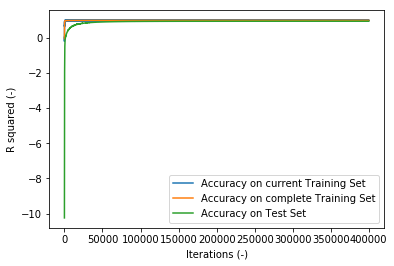

In [15]:
plt.plot( iterations, performance_train_current, label = 'Accuracy on current Training Set' )

plt.plot( iterations, performance_train_complete, label = 'Accuracy on complete Training Set' )

plt.plot( iterations, performance_test, label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'R squared (-)' )

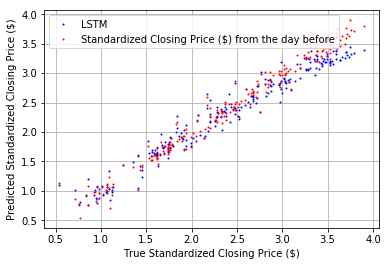

In [16]:
plt.plot( test_y, sess.run( output, feed_dict = { x_tf : test_x } ), 'bo', markersize = 1, label = 'LSTM' )

plt.plot( test_y, test_x[ :, 31 ], 'ro', markersize = 1, label = 'Standardized Closing Price ($) from the day before' )

plt.xlabel( 'True Standardized Closing Price ($)' )

plt.ylabel( 'Predicted Standardized Closing Price ($)' )

plt.legend( loc = 'best' )

plt.grid()

In the plot above, we compare two predictors: in blue the LSTM, in red the closing price from the day before. In general, the LSTM seems to be closer to the diagonal, which means, that the LSTM is a better predictor than the closing price from the day before. However: when the closing price that is to be predicted is greater than $2.5$, the LSTM performs worse than the closing price from the day before. This can be explained with the fact, that we used the first $4$ years to train the LSTM, and in the fifth year, prices were reached, that the LSTM hasn't seen before.<br>
We introduced the grid for better visibility by using [grid](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.grid.html).

Text(0, 0.5, 'R squared (-)')

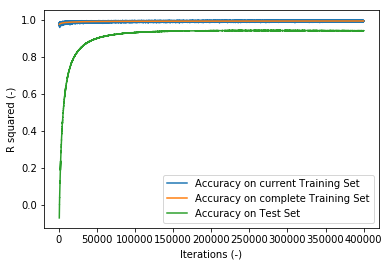

In [17]:
plt.plot( iterations[ 1000 : len( performance_train_current ) ], 
         performance_train_current[ 1000 : len( performance_train_current ) ], label = 'Accuracy on current Training Set' )

plt.plot( iterations[ 1000 : len( performance_train_current ) ],
         performance_train_complete[ 1000 : len( performance_train_current ) ], label = 'Accuracy on complete Training Set' )

plt.plot( iterations[ 1000 : len( performance_train_current ) ],
         performance_test[ 1000 : len( performance_train_current ) ], label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'R squared (-)' )

Text(0, 0.5, 'R squared (-)')

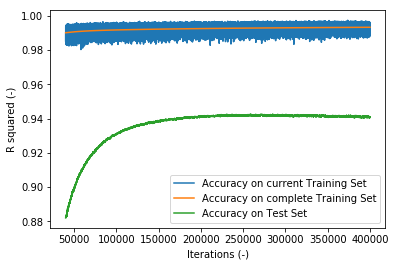

In [18]:
plt.plot( iterations[ 40000 : len( performance_train_current ) ], 
         performance_train_current[ 40000 : len( performance_train_current ) ], label = 'Accuracy on current Training Set' )

plt.plot( iterations[ 40000 : len( performance_train_current ) ],
         performance_train_complete[ 40000 : len( performance_train_current ) ], label = 'Accuracy on complete Training Set' )

plt.plot( iterations[ 40000 : len( performance_train_current ) ],
         performance_test[ 40000 : len( performance_train_current ) ], label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'R squared (-)' )

In [19]:
sess.close()

In this lesson, we trained our first LSTM. We achieved a decent accuracy, which still can be improved. For now, we close this lesson. Class dismissed.